In [1]:
## Created on Sun, Dec 9, 2018
## @ Author: Harry Zhao
## Improvement on previous work with same intuition on tf-idf by appying nltk

Provide an efficient and sophisticated way to figure out what words are trending. Use the provided input which is a large collection of news texts with timestamps. Your method and interpretation of trending is up to you but please state your rationale and assumptions in clear flow. The submission will be considered with regards to

1. method,
2. analysis,
3. programming,
4. communication skills,
5. quality of results,
6. and discussion of results.

### Assumptions & Method:

1. Only focus on English content (same algorithm can be applied to other languages)
2. Keywords normalized using word count vs. total word count in each time window
3. Use sliding observation-window identified by equal number of articles (~30)
4. "Trend" need to meet the following conditions to remove noise:  
    a. increase of "normalized frequency" from previous period (t-2 to t-1 and t-1 to t)   
    b. "normalized frequency" above unconditional mean
    c. show up in at least three consecutive time window

In [2]:
import pandas as pd
import numpy as np
import re
import datetime
import xlrd
import matplotlib as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

### Load and Clean data

In [3]:
# Excel file preprocessed manually by removing rows without "Time" column
text_table = pd.read_excel('rna002_RTRS_2017_11_29.xlsx') 
print(text_table.shape)
print(text_table.columns)
# remove rows that indicates "please ignore"
text_table = text_table[text_table.HEADLINE_ALERT_TEXT.str.contains("Test, Please Ignore")==False]

print(text_table.shape)
text_table.LANGUAGE.value_counts()

#### Most documents are in English, so focus on it first

text_table = text_table[text_table['LANGUAGE']=='EN']
## Use Headline when no Take Text is available
text_table.loc[text_table['TAKE_TEXT'].isnull(),'TAKE_TEXT'] = text_table.loc[text_table['TAKE_TEXT'].isnull(),'HEADLINE_ALERT_TEXT']

(8137, 19)
Index(['DATE', 'TIME', 'UNIQUE_STORY_INDEX', 'EVENT_TYPE', 'PNAC',
       'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'HEADLINE_ALERT_TEXT',
       'ACCUMULATED_STORY_TEXT', 'TAKE_TEXT', 'PRODUCTS', 'TOPICS',
       'RELATED_RICS', 'NAMED_ITEMS', 'HEADLINE_SUBTYPE', 'STORY_TYPE',
       'TABULAR_FLAG', 'ATTRIBUTION', 'LANGUAGE'],
      dtype='object')
(6542, 19)


In [4]:
str.replace?

In [5]:
text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: re.sub('\d+','',x))

text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: re.sub(r'[\*|\+|\_|\-|\<||>|\(|\)]','',x))

text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: str.lower(x))

text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: x.replace('reuters','').replace('thomson',''))

text_table = text_table[text_table["TAKE_TEXT"].notnull()]
text_table['TAKE_TEXT']

0       mercator minerals announces senior management ...
1       s.korea says may trade balance at provisional ...
5       mercator minerals announces senior management ...
6       s.korea says may exports . pct vs yr earlier  ...
11      s.korea says may imports . pct vs yr earlier  ...
12      s.korea may avg exports per working day $. bln...
14                    star buffet, inc. sells real estate
17      update golfhaas takes memorial lead, woods lab...
18           haas moves three ahead after firing a  \n...
22             sports schedule at  gmt on saturday, june 
23           sports schedule at  gmt on saturday: \n  ...
25                            top news investment banking
26       for expanded, multimedia  top news visit:  \n...
27      milewide tornado touches down west of oklahoma...
28          may    a milewide tornado has touched down...
31      update venezuela's economy slows sharply as 's...
32           economy grew . pct in q vs . pct a year e...
35      direct

In [6]:
text_table['TAKE_TEXT'][0]

'mercator minerals announces senior management changes'

In [8]:
porter= nltk.stem.PorterStemmer()

In [9]:
text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: str([porter.stem(i) for i in nltk.word_tokenize(x)]))

In [11]:
stopwordsList = stopwords.words()

In [12]:
# vectorize each row of document using tf-idf featrue extraction

vect = TfidfVectorizer(min_df=4, ngram_range=(1,2), stop_words=stopwordsList).fit(text_table['TAKE_TEXT'])

vectorized_text = vect.transform(text_table['TAKE_TEXT'])

text_table['vectorized_text'] = [i for i in vectorized_text]

In [13]:
feature_names = vect.get_feature_names()
len(feature_names)

17925

### Generate time window, and count words in each window

#### Note: skewed distribution of text length in each time window; this requires normalization within each document

In [14]:
text_table['date_time'] = list(map (lambda x, y: datetime.datetime.combine(x,y) , text_table['DATE'], text_table['TIME']))

text_table['take_text_length'] = text_table['TAKE_TEXT'].str.len()
text_table.hist(['take_text_length'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a213cb9e8>]],
      dtype=object)

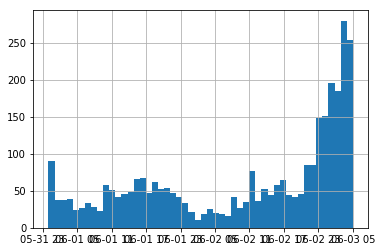

In [15]:
text_table.date_time.hist(bins= 50)

#### Note: skewed time distribution of document, use equal no. of document for time bins.

In [16]:
print(text_table['date_time'].min())
print(text_table['date_time'].max())
text_table['time_window'] = pd.qcut(text_table['date_time'],100)
text_table['time_window'].value_counts()

2013-06-01 00:00:00.704000
2013-06-03 04:59:53.681000


(2013-06-03 01:21:45.579599872, 2013-06-03 01:31:05.217999872]    33
(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]    33
(2013-06-02 14:40:34.414040064, 2013-06-02 15:23:35.004999936]    33
(2013-06-03 04:54:17.649080064, 2013-06-03 04:59:53.680999936]    32
(2013-06-01 23:44:28.395399936, 2013-06-02 01:05:55.168519936]    32
(2013-06-02 23:02:52.652080128, 2013-06-02 23:15:17.611040]       32
(2013-06-02 22:35:31.613280, 2013-06-02 22:54:52.357560064]       32
(2013-06-02 21:14:21.811640064, 2013-06-02 21:52:02.623080192]    32
(2013-06-02 19:55:53.497799936, 2013-06-02 20:34:21.487160064]    32
(2013-06-02 17:36:27.529600, 2013-06-02 18:15:59.527800064]       32
(2013-06-02 12:27:57.829359872, 2013-06-02 13:11:32.545799936]    32
(2013-06-02 10:51:34.677760, 2013-06-02 11:21:52.039800064]       32
(2013-06-02 07:53:45.883680, 2013-06-02 08:35:48.616000]          32
(2013-06-02 03:02:08.103200, 2013-06-02 04:28:21.894000128]       32
(2013-06-01 21:30:12.949199872, 20

In [17]:
text_table_by_window= pd.DataFrame(text_table.groupby(['time_window'])['vectorized_text'].sum(axis=0))

### For each window: 1. Filter words that have higher than average frequency in full sample; 2. Identify words that have increase relative frequency in the last 4 time windows (including current)

In [18]:
text_table_by_window.shape

(100, 1)

In [19]:
output = text_table_by_window
output['result'] = None
#output['tfidf'] = None

In [20]:
for i in range(3,text_table_by_window.shape[0]):
    
    l = list()
    
    list_1 =  text_table_by_window.iloc[i,0].toarray()[0]
    list_2 = text_table_by_window.iloc[i-1,0].toarray()[0]
    list_3 = text_table_by_window.iloc[i-2,0].toarray()[0]
    list_4 = text_table_by_window.iloc[i-3,0].toarray()[0]
    
    average_list = (list_1 + list_2 + list_3 + list_4)/4
    
    # salient = (average_list > 0.03) & (average_list <0.5)
    nonzero = list_4 > 0
    growth_1 = (list_1 - list_2) > 0
    growth_2 = (list_2 - list_3) > 0
    growth_3 = (list_3 - list_4) > 0
    
    X = growth_1 & growth_2 & growth_3 & nonzero
    l = [feature_names[i] for i in range(X.shape[0]) if X[i] == True]
    # n = [average_list[i] for i in range(X.shape[0]) if X[i] == True]
    
    output.iloc[i,1]= l  
    # output.iloc[i,2]= n

# X= pd.DataFrame(index= np.transpose(output.iloc[2,1]), data = np.transpose(output.iloc[2,2]),columns=['tfidf'])
# X.sort_values('tfidf', ascending=False)

### Spot check and save results to excel

In [21]:
output.iloc[14,1]

['edit',
 'first',
 'hi',
 'may',
 'messag',
 'net',
 'net keyword',
 'th',
 'time',
 'year']

In [22]:
output['result'].apply(lambda x: len(x) if x is not None else 0)

time_window
(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]      0
(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]      0
(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]      0
(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]     11
(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]         9
(2013-06-01 03:02:55.562400, 2013-06-01 03:50:58.106840064]         7
(2013-06-01 03:50:58.106840064, 2013-06-01 05:01:08.552719872]      7
(2013-06-01 05:01:08.552719872, 2013-06-01 05:59:11.477560064]      5
(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]      6
(2013-06-01 07:19:41.688999936, 2013-06-01 08:24:46.328600064]      9
(2013-06-01 08:24:46.328600064, 2013-06-01 09:52:36.634560]         8
(2013-06-01 09:52:36.634560, 2013-06-01 10:07:04.633560064]         1
(2013-06-01 10:07:04.633560064, 2013-06-01 11:00:00.669760]         2
(2013-06-01 11:00:00.669760, 2013-06-01 11:32:06.976599808]         3
(2013-06

In [23]:
# Save trend word list in each time window
writer = pd.ExcelWriter('Output.xlsx')
output.result.to_excel(writer,'Sheet1')

# Save total appearance in full period for each trending word
trend_word_dict = output.result.apply(lambda x: Counter(x)).sum()
trend_word_list = pd.DataFrame.from_dict(trend_word_dict,orient ='index', columns=['Appearance']).sort_values(by=['Appearance'], ascending = False)

trend_word_list.to_excel(writer,'Sheet2')
trend_word_list

,Appearance
percent,10
updat,9
edit,8
messag,8
power,8
oil,8
expect,7
top,7
keyword,7
wa,7


In [24]:
output

,vectorized_text,result
time_window,,
"(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]","(0, 4979)\t0.37098630932801624\n (0, 6305)\...",None
"(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]","(0, 3630)\t0.336126489277826\n (0, 4548)\t0...",None
"(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]","(0, 1389)\t0.5051739707249986\n (0, 11840)\...",None
"(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]","(0, 6115)\t0.3746064342477196\n (0, 6116)\t...","[commod top, data, ga, http topnews, rservices..."
"(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]","(0, 42)\t0.09616177287209192\n (0, 48)\t0.1...","[home, keyword, least, order, state, talk, tar..."
"(2013-06-01 03:02:55.562400, 2013-06-01 03:50:58.106840064]","(0, 17461)\t0.5334414184558597\n (0, 6348)\...","[bill, includ, lisa, oil, statement, stock, ta..."
"(2013-06-01 03:50:58.106840064, 2013-06-01 05:01:08.552719872]","(0, 87)\t0.10523606818486124\n (0, 1069)\t0...","[ensur, includ, lisa, million, oil, push, target]"
"(2013-06-01 05:01:08.552719872, 2013-06-01 05:59:11.477560064]","(0, 49)\t0.2200665211365853\n (0, 50)\t0.08...","[compani, effort, houston, million, tri]"
"(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]","(0, 191)\t0.11718540238632588\n (0, 192)\t0...","[critic, edit, go, major, million, still]"


In [25]:
# # Save time window for each trending word
trend_word_list_by_time_window = dict()
for key in trend_word_dict.keys():
        trend_word_list_by_time_window[key] = \
        list(output[output['result'].apply(lambda x: x is not None and key in x)].index)


In [26]:
trend_word_list_by_time_window

{'commod top': [Interval('2013-06-01 01:07:57.614840064', '2013-06-01 01:57:57.029240064', closed='right'),
  Interval('2013-06-01 12:09:43.110599936', '2013-06-01 13:05:45.506720', closed='right'),
  Interval('2013-06-03 00:32:50.928599808', '2013-06-03 00:46:38.474680064', closed='right')],
 'data': [Interval('2013-06-01 01:07:57.614840064', '2013-06-01 01:57:57.029240064', closed='right'),
  Interval('2013-06-02 22:18:01.296199936', '2013-06-02 22:35:31.613280', closed='right'),
  Interval('2013-06-03 00:46:38.474680064', '2013-06-03 01:00:10.828600064', closed='right')],
 'ga': [Interval('2013-06-01 01:07:57.614840064', '2013-06-01 01:57:57.029240064', closed='right'),
  Interval('2013-06-01 22:30:31.642560', '2013-06-01 23:44:28.395399936', closed='right'),
  Interval('2013-06-03 00:25:05.121999872', '2013-06-03 00:32:50.928599808', closed='right'),
  Interval('2013-06-03 00:32:50.928599808', '2013-06-03 00:46:38.474680064', closed='right')],
 'http topnews': [Interval('2013-06-01

In [27]:

trend_word_window_list = pd.DataFrame.from_dict(trend_word_list_by_time_window, orient ='index',\
                       columns=['w1','w2','w3','w4','w5','w6','w7','w8','w9','w10'])

trend_word_window_list.to_excel(writer,'Sheet3')

In [28]:
writer.save()

### Sanity Check

In [29]:
text_table_by_window

,vectorized_text,result
time_window,,
"(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]","(0, 4979)\t0.37098630932801624\n (0, 6305)\...",None
"(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]","(0, 3630)\t0.336126489277826\n (0, 4548)\t0...",None
"(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]","(0, 1389)\t0.5051739707249986\n (0, 11840)\...",None
"(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]","(0, 6115)\t0.3746064342477196\n (0, 6116)\t...","[commod top, data, ga, http topnews, rservices..."
"(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]","(0, 42)\t0.09616177287209192\n (0, 48)\t0.1...","[home, keyword, least, order, state, talk, tar..."
"(2013-06-01 03:02:55.562400, 2013-06-01 03:50:58.106840064]","(0, 17461)\t0.5334414184558597\n (0, 6348)\...","[bill, includ, lisa, oil, statement, stock, ta..."
"(2013-06-01 03:50:58.106840064, 2013-06-01 05:01:08.552719872]","(0, 87)\t0.10523606818486124\n (0, 1069)\t0...","[ensur, includ, lisa, million, oil, push, target]"
"(2013-06-01 05:01:08.552719872, 2013-06-01 05:59:11.477560064]","(0, 49)\t0.2200665211365853\n (0, 50)\t0.08...","[compani, effort, houston, million, tri]"
"(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]","(0, 191)\t0.11718540238632588\n (0, 192)\t0...","[critic, edit, go, major, million, still]"


In [30]:
text_table_by_window['trending_words'] = text_table_by_window['result'].apply(lambda x: len(x) if x is not None else 0)

In [31]:
text_table_by_window.columns

Index(['vectorized_text', 'result', 'trending_words'], dtype='object')

In [32]:
text_table_by_window.head()

,vectorized_text,result,trending_words
time_window,,,
"(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]","(0, 4979)\t0.37098630932801624\n (0, 6305)\...",None,0
"(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]","(0, 3630)\t0.336126489277826\n (0, 4548)\t0...",None,0
"(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]","(0, 1389)\t0.5051739707249986\n (0, 11840)\...",None,0
"(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]","(0, 6115)\t0.3746064342477196\n (0, 6116)\t...","[commod top, data, ga, http topnews, rservices...",11
"(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]","(0, 42)\t0.09616177287209192\n (0, 48)\t0.1...","[home, keyword, least, order, state, talk, tar...",9


In [33]:
# text_table_by_window.plot.scatter(x= ['total_words'], y = ['trending_words'])

#### Results not correlated with the number of total words in each window. 
#### As shown below, there is no clear clustering in time blocks either.

In [34]:
text_table_by_window[text_table_by_window['trending_words']>40]['trending_words']

time_window
(2013-06-01 22:30:31.642560, 2013-06-01 23:44:28.395399936]        43
(2013-06-03 00:25:05.121999872, 2013-06-03 00:32:50.928599808]    168
(2013-06-03 00:32:50.928599808, 2013-06-03 00:46:38.474680064]     73
(2013-06-03 02:20:51.619800064, 2013-06-03 02:33:56.376320]       110
(2013-06-03 04:54:17.649080064, 2013-06-03 04:59:53.680999936]     52
Name: trending_words, dtype: int64

### Immediate Improvement:
1. Add bigram to improve word group
2. Clean for Synonyms 
3. Combine with NLP topic modelling- instead of "words", use "topic"
4. Finer treatment of words in title vs. words in main text (words in title should be given more weight)